1. Import all required libraries to access CSV file on Drive, read, clean and analyse it, and present the results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_style("whitegrid")
plt.style.use('ggplot')
pd.set_option('display.max_columns', 25)
from google.colab import drive

2. Mount Google Drive and define the path to required CSV.

In [2]:
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/CLV/clv_analysis.csv'

Mounted at /content/drive


3. Read and inspect CSV file.

In [3]:
try:
    df = pd.read_csv(file_path, header=0)
    print("Dataframe shape:")
    print(df.shape)
    print()
    print("Initial Dataframe Head:")
    print(df.head())
    print()
    print("\nInitial Dataframe Columns:")
    print(df.columns)
    print()
    print("\nInitial Dataframe Info:")
    print(df.info())
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}. Please check the path and try again.")
    exit()

Dataframe shape:
(2381, 10)

Initial Dataframe Head:
   user_pseudo_id category         country subscription_start Week Starts  \
0    1.005695e+06  desktop           India         2020-11-01  2020-11-01   
1    1.013443e+06   mobile   United States         2020-11-01  2020-11-01   
2    1.014060e+06  desktop   United States         2020-11-01  2020-11-01   
3    1.014271e+06  desktop  United Kingdom         2020-11-01  2020-11-01   
4    1.025449e+06  desktop           Spain         2020-11-01  2020-11-01   

    Week ENDS Week Purchase date  Purchase amount Currency  
0  2020-11-07  W_0    2020-11-01            15.98      USD  
1  2020-11-07  W_0    2020-11-01            26.73      USD  
2  2020-11-07  W_0    2020-11-01            27.34      USD  
3  2020-11-07  W_0    2020-11-01             7.81      USD  
4  2020-11-07  W_0    2020-11-02            20.97      USD  


Initial Dataframe Columns:
Index(['user_pseudo_id', 'category', 'country', 'subscription_start',
       'Week Starts

4. Data cleaning and preparation.

In [4]:
# 4.1. Remove any columns that are entirely empty
df = df.dropna(axis=1, how='all')

# 4.2. Change column names to lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# 4.3. Ensure that the purchase_amount column is a clean number
df['purchase_amount'] = df['purchase_amount'].astype(str).str.replace('$', '', regex=False).str.replace(',', '.', regex=False).str.strip().astype(float)

# 4.4. Convert date columns to datetime objects
date_columns = ['subscription_start', 'week_starts', 'week_ends', 'purchase_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# 4.5. Drop rows with invalid 'amount_in_usd' values
df = df.dropna(subset=['purchase_amount'])

5. Check for any missing values after cleaning.

In [5]:
print("Missing values:")
print(df.isna().sum())

Missing values:
user_pseudo_id        0
category              0
country               0
subscription_start    0
week_starts           0
week_ends             0
week                  0
purchase_date         0
purchase_amount       0
currency              0
dtype: int64


6. Check for any duplicate rows.

In [6]:
print(df.loc[df.duplicated()])

Empty DataFrame
Columns: [user_pseudo_id, category, country, subscription_start, week_starts, week_ends, week, purchase_date, purchase_amount, currency]
Index: []


7. Get initial insights about the data.

In [7]:
df.describe(include='all')

,user_pseudo_id,category,country,subscription_start,week_starts,week_ends,week,purchase_date,purchase_amount,currency
count,2.381000e+03,2381,2381,2381,2381,2381,2381,2381,2381.000000,2381
unique,NaN,3,92,NaN,NaN,NaN,7,NaN,NaN,1
top,NaN,desktop,United States,NaN,NaN,NaN,W_0,NaN,NaN,USD
freq,NaN,1379,1100,NaN,NaN,NaN,600,NaN,NaN,2381
mean,2.360452e+08,NaN,NaN,2020-11-14 12:00:18.143636992,2020-11-27 21:36:39.916001536,2020-12-03 20:20:27.719445504,NaN,2020-11-30 21:54:48.534229248,14.684229,NaN
min,1.001569e+06,NaN,NaN,2020-11-01 00:00:00,2020-11-01 00:00:00,2020-11-07 00:00:00,NaN,2020-11-01 00:00:00,0.500000,NaN
25%,5.502627e+06,NaN,NaN,2020-11-01 00:00:00,2020-11-22 00:00:00,2020-11-28 00:00:00,NaN,2020-11-22 00:00:00,7.060000,NaN
50%,2.207209e+07,NaN,NaN,2020-11-15 00:00:00,2020-11-29 00:00:00,2020-12-05 00:00:00,NaN,2020-12-03 00:00:00,14.770000,NaN
75%,6.041898e+07,NaN,NaN,2020-11-22 00:00:00,2020-12-06 00:00:00,2020-12-12 00:00:00,NaN,2020-12-11 00:00:00,22.170000,NaN
max,9.657667e+09,NaN,NaN,2020-12-13 00:00:00,2020-12-13 00:00:00,2020-12-19 00:00:00,NaN,2020-12-19 00:00:00,29.000000,NaN


8. Customer Lifetime Value Analysis.

In [8]:
# 8.1. Group data by pseudo_user_id to calculate their total spend
customer_data = df.groupby('user_pseudo_id').agg(
    total_revenue=pd.NamedAgg(column='purchase_amount', aggfunc='sum'),
    first_purchase_date=pd.NamedAgg(column='purchase_date', aggfunc='min')
).reset_index()

# 8.2. Merge back with the original dataframe to get customer-level data
clv_df = pd.merge(customer_data, df[['user_pseudo_id', 'category', 'country']].drop_duplicates(), on='user_pseudo_id', how='left')

# 8.3. Drop rows where 'category' or 'country' is empty
clv_df = clv_df.dropna(subset=['category', 'country'])

# 8.4. Summary of Key Metrics
total_customers = customer_data['user_pseudo_id'].nunique()
total_revenue = customer_data['total_revenue'].sum()
average_clv = customer_data['total_revenue'].mean()

print("\n--- Summary of Key Metrics ---")
print(f"Total Customers: {total_customers}")
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Average Customer Lifetime Value (CLV): ${average_clv:,.2f}")


--- Summary of Key Metrics ---
Total Customers: 2381
Total Revenue: $34,963.15
Average Customer Lifetime Value (CLV): $14.68


9. Analyze CLV by Category and Country.

In [9]:
# 9.1. CLV Analysis by Category
category_analysis = df.groupby('category').agg(
    total_customers=pd.NamedAgg(column='user_pseudo_id', aggfunc='nunique'),
    average_clv=pd.NamedAgg(column='purchase_amount', aggfunc='mean'),
    total_revenue=pd.NamedAgg(column='purchase_amount', aggfunc='sum')
).sort_values(by='total_revenue', ascending=False)

# Calculate average CLV by Category: divide the total revenue by the number of unique customers.
category_analysis['average_clv'] = category_analysis['total_revenue'] / category_analysis['total_customers']

print("\n--- CLV Analysis by Category ---")
print(category_analysis)

# 9.2. CLV Analysis by Country
country_analysis = df.groupby('country').agg(
    total_customers=pd.NamedAgg(column='user_pseudo_id', aggfunc='nunique'),
    average_clv=pd.NamedAgg(column='purchase_amount', aggfunc='mean'),
    total_revenue=pd.NamedAgg(column='purchase_amount', aggfunc='sum')
).sort_values(by='total_revenue', ascending=False)

# Calculate average CLV by Coutry: divide the total revenue by the number of unique customers.
country_analysis['average_clv'] = country_analysis['total_revenue'] / country_analysis['total_customers']

# 9.3. Select top 10 countries for a cleaner visual representation
top_10_countries = country_analysis.head(10)

print("\n--- CLV Analysis by Country (Top 10 by Revenue) ---")
print(top_10_countries)


--- CLV Analysis by Category ---
          total_customers  average_clv  total_revenue
category                                             
desktop              1379    14.628898       20173.25
mobile                955    14.645529       13986.48
tablet                 47    17.094043         803.42

--- CLV Analysis by Country (Top 10 by Revenue) ---
                total_customers  average_clv  total_revenue
country                                                    
United States              1100    14.868373       16355.21
India                       228    14.645263        3339.12
Canada                      166    15.322048        2543.46
United Kingdom              109    15.001835        1635.20
France                       50    13.117200         655.86
Taiwan                       47    13.734894         645.54
Germany                      41    14.535122         595.94
China                        36    14.309167         515.13
Japan                        32    13.62500

10. Analyze and Visualise the Data for all Cohorts.

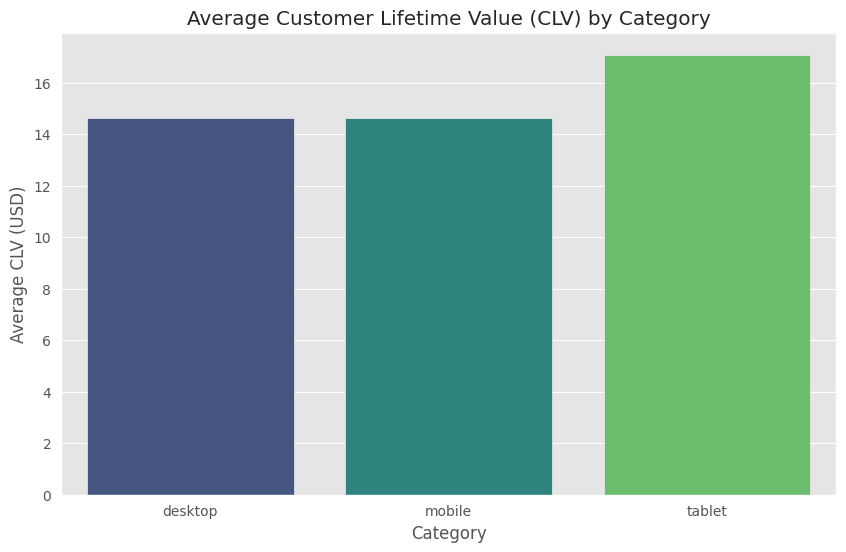

In [10]:
# 10.1. Bar chart for Average CLV by Category
plt.figure(figsize=(10, 6))
sns.barplot(x=category_analysis.index, y=category_analysis['average_clv'], palette='viridis', hue=category_analysis.index, legend=False)
plt.title('Average Customer Lifetime Value (CLV) by Category')
plt.xlabel('Category')
plt.ylabel('Average CLV (USD)')
plt.show()

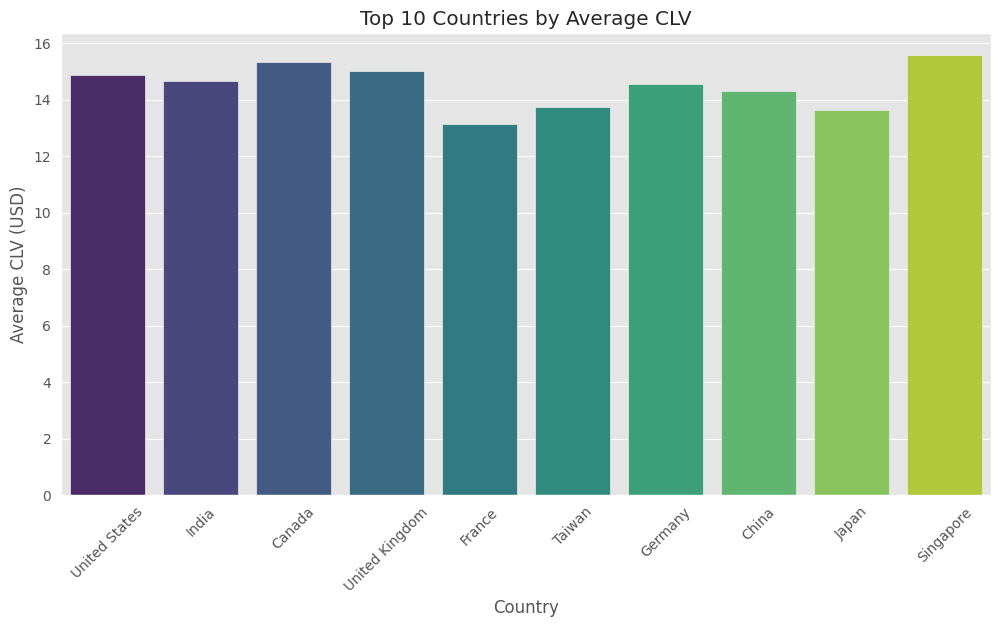

In [11]:
# 10.2. Bar chart for Average CLV by Country (Top 10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_countries.index, y=top_10_countries['average_clv'], palette='viridis', hue=top_10_countries.index, legend=False)
plt.title('Top 10 Countries by Average CLV')
plt.xlabel('Country')
plt.ylabel('Average CLV (USD)')
plt.xticks(rotation=45)
plt.show()

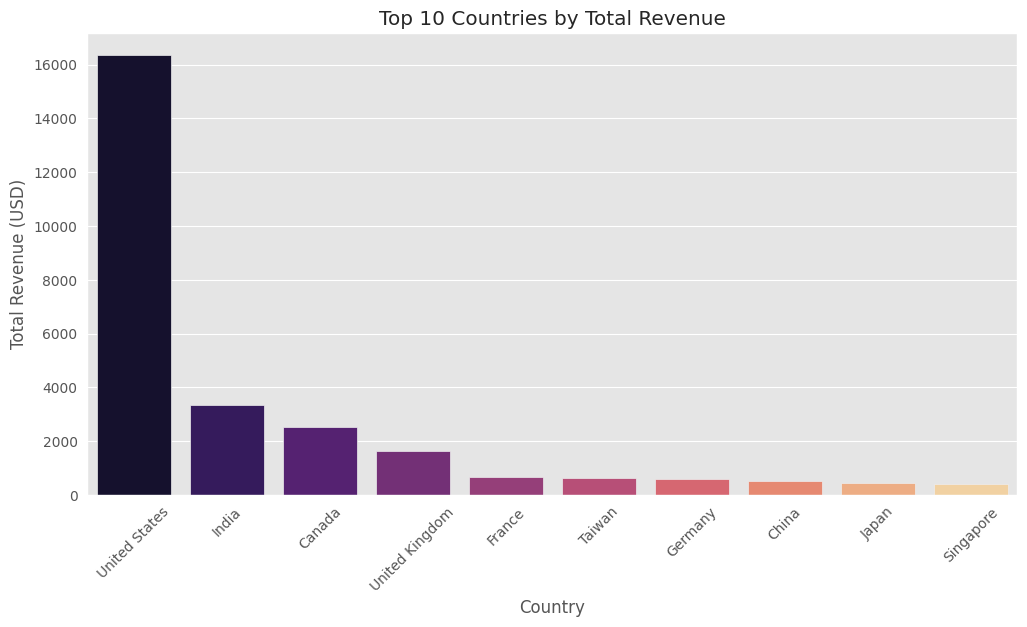

In [12]:
# 10.3. Bar chart for Total Revenue by Country (Top 10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_countries.index, y=top_10_countries['total_revenue'], palette='magma', hue=top_10_countries.index, legend=False)
plt.title('Top 10 Countries by Total Revenue')
plt.xlabel('Country')
plt.ylabel('Total Revenue (USD)')
plt.xticks(rotation=45)
plt.show()

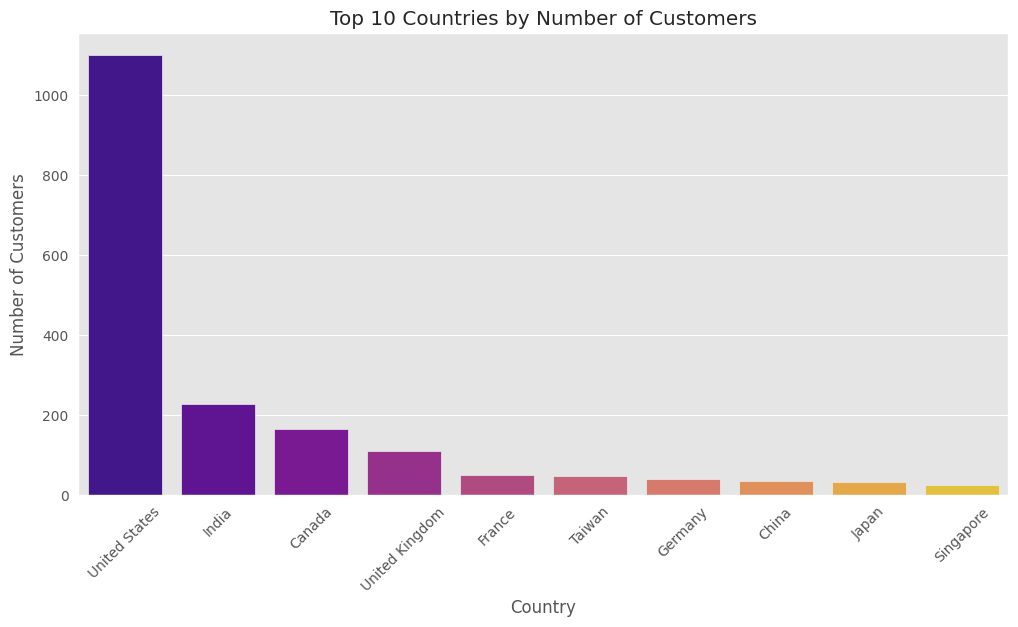

In [13]:
# 10.4. Bar chart for Number of Customers by Country (Top 10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_countries.index, y=top_10_countries['total_customers'], palette='plasma', hue=top_10_countries.index, legend=False)
plt.title('Top 10 Countries by Number of Customers')
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

11. Analyze and Vizualize Data by Cohorts.

In [14]:
# 11.1. Create cohorts by 'subscription_start' date.
df['cohort_start_date'] = df['subscription_start'].dt.date
daily_cohorts = df.groupby('cohort_start_date')
daily_cohort_sizes = daily_cohorts['user_pseudo_id'].count()
print(daily_cohort_sizes)

cohort_start_date
2020-11-01    610
2020-11-08    480
2020-11-15    427
2020-11-22    412
2020-11-29    259
2020-12-06    172
2020-12-13     21
Name: user_pseudo_id, dtype: int64


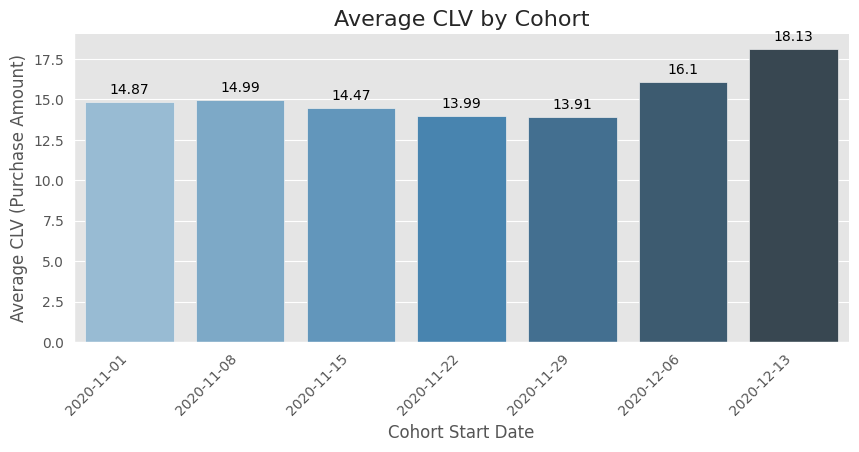

In [15]:
# 11.2 Calculate average CLV by cohort and display results in a bar chart.
cohort_clv = df.groupby('cohort_start_date').agg(
    total_purchase_amount=('purchase_amount', 'sum'),
    num_customers=('user_pseudo_id', 'count')
).reset_index()

cohort_clv['average_clv'] = cohort_clv['total_purchase_amount'] / cohort_clv['num_customers']

plt.figure(figsize=(10, 4))
bar_plot = sns.barplot(
    x='cohort_start_date',
    y='average_clv',
    data=cohort_clv,
    hue='cohort_start_date',
    palette='Blues_d',
    legend=False
)

for index, row in cohort_clv.iterrows():
    bar_plot.text(index, row.average_clv + 0.5, round(row.average_clv, 2), color='black', ha="center")

plt.title('Average CLV by Cohort', fontsize=16)
plt.xlabel('Cohort Start Date', fontsize=12)
plt.ylabel('Average CLV (Purchase Amount)', fontsize=12)
plt.xticks(rotation=45, ha='right')

sns.despine()

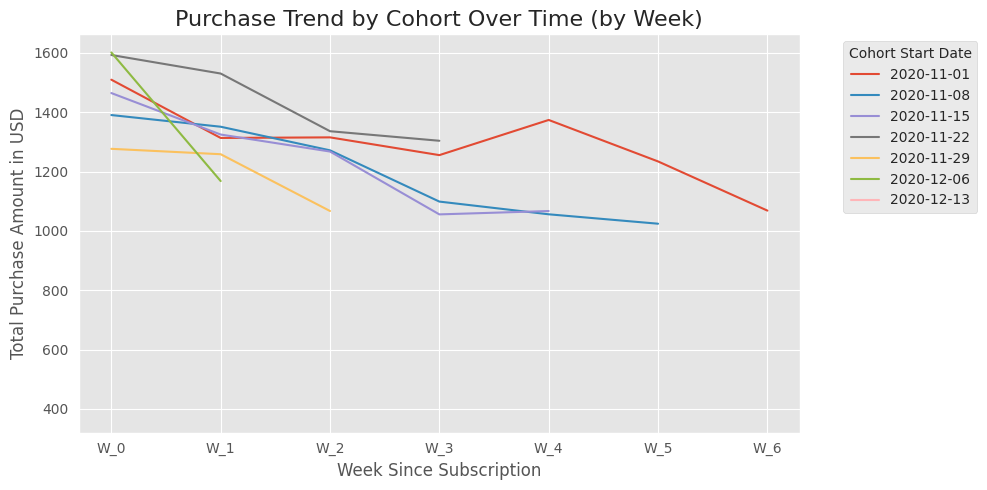

In [16]:
# 11.3. Analyse change of total revenue for each cohort by week.
cohort_trends = df.groupby(['cohort_start_date', 'week'])['purchase_amount'].sum().reset_index()

cohort_pivot = cohort_trends.pivot_table(index='week', columns='cohort_start_date', values='purchase_amount')

# Ensure the 'week' index is sorted correctly for plotting (W_0, W_1, ...)
cohort_pivot.index = pd.Categorical(cohort_pivot.index, categories=[f'W_{i}' for i in range(7)], ordered=True)
cohort_pivot = cohort_pivot.sort_index()

plt.figure(figsize=(10, 5))
for col in cohort_pivot.columns:
    plt.plot(cohort_pivot.index, cohort_pivot[col], label=col)

plt.title('Purchase Trend by Cohort Over Time (by Week)', fontsize=16)
plt.xlabel('Week Since Subscription', fontsize=12)
plt.ylabel('Total Purchase Amount in USD', fontsize=12)
plt.legend(title='Cohort Start Date', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

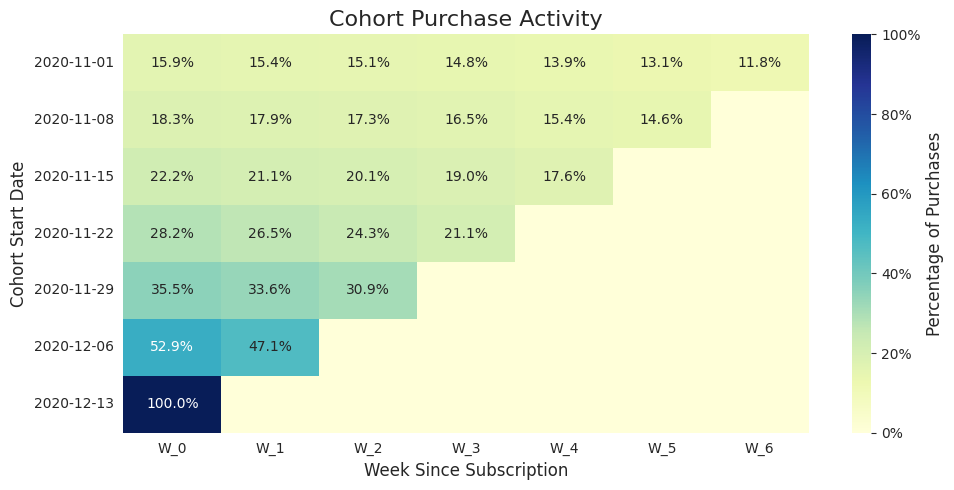

In [17]:
# 11.3. Analyze Purchase Activity by Cohorts Weekly.
purchases_by_cohort_week = df.groupby(['cohort_start_date', 'week']).size().unstack(fill_value=0)

retention_matrix = purchases_by_cohort_week.div(purchases_by_cohort_week.sum(axis=1), axis=0)
last_column = purchases_by_cohort_week.columns[-1]
retention_matrix[last_column] = 1.0 - retention_matrix.iloc[:, :-1].sum(axis=1)

# Ensure the 'week' columns are sorted correctly for the plot
sorted_weeks = [f'W_{i}' for i in range(7)]
retention_matrix = retention_matrix.reindex(columns=sorted_weeks)

# Create the heatmap for visualization
sns.set_style("white")
plt.figure(figsize=(10, 5))
annot_labels = retention_matrix.map(lambda x: f'{x:.1%}' if x > 0 else '')

sns.heatmap(
retention_matrix,
annot=annot_labels,
fmt="",
cmap="YlGnBu",
cbar_kws={
'label': 'Percentage of Purchases',
'format': mtick.PercentFormatter(1.0)
}
)

# Set the plot's title and axis labels for clarity
plt.title('Cohort Purchase Activity', fontsize=16)
plt.xlabel('Week Since Subscription', fontsize=12)
plt.ylabel('Cohort Start Date', fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()

8. Save the cleaned data to a new CSV file in Drive for analysis in Tableau.

In [18]:
# Export the entire DataFrame to a single CSV file (excluding 'cohort_start_date' column).

df = df.drop(columns=['cohort_start_date'])

df.to_csv('cleaned_data_for_tableau.csv', index=False)
print("Cleaned and renamed data saved to 'cleaned_data_for_tableau.csv' for Tableau analysis.")

Cleaned and renamed data saved to 'cleaned_data_for_tableau.csv' for Tableau analysis.
